# 🧠 미션 10: 뉴스 텍스트 분류 모델 구현

## 📘 미션 소개
이번 미션은 **텍스트 데이터와 임베딩 기법을 활용한 뉴스 기사 분류**를 목표로 합니다.  
자연어 처리(NLP)의 기본 구조를 익히고, 임베딩과 RNN 기반 모델링 과정을 직접 구현해 봅니다.

---

## 🎯 미션 목표
- 텍스트 데이터를 전처리하고 훈련/테스트 세트로 분리한다.  
- Word2Vec, FastText, GloVe 임베딩을 적용하여 입력 벡터를 생성한다.  
- RNN 계열(LSTM, GRU)의 딥러닝 모델을 구성하고 학습한다.  
- 각 임베딩 방식별 성능을 비교하고 분석한다.  
- Accuracy, Precision, Recall, F1-score 등 주요 지표로 모델 성능을 평가한다.

---

## 📂 데이터 소개
- **데이터셋명**: 20 Newsgroups Dataset  
- **출처**: scikit-learn 내장 데이터셋  
- **데이터 크기**: 18,846개의 뉴스 문서  
- **카테고리 수**: 20개  
- **데이터 구조**
  - `data`: 텍스트 문서 리스트  
  - `target`: 각 문서의 카테고리 인덱스

---

## ⚙️ 분석 및 구현 단계
### 1️⃣ 데이터 전처리
- 특수문자 제거, 소문자 변환, 불용어(stopwords) 제거  
- 토큰화(tokenization) 수행  
- 훈련 데이터 / 테스트 데이터 분리  

### 2️⃣ 임베딩 적용
- **Word2Vec**, **FastText**, **GloVe** 중 3가지 임베딩 기법을 각각 적용  
- 각 단어의 벡터를 평균 또는 시퀀스로 입력하도록 구성  
- 임베딩 결과를 PyTorch의 `Embedding` 레이어로 연동  

### 3️⃣ 데이터셋 및 로더 구현
- PyTorch의 `Dataset` 클래스를 상속하여 문장-레이블 구조로 정의  
- `DataLoader`를 통해 배치 단위 학습 가능하도록 구현  

### 4️⃣ 모델 설계
- **기본 구조**
Embedding Layer → LSTM / GRU Layer → Fully Connected → Softmax
- Dropout, Bidirectional LSTM 등 구조적 개선 시도 가능  

### 5️⃣ 모델 학습 및 평가
- **손실 함수**: CrossEntropyLoss  
- **최적화 알고리즘**: Adam  
- **평가지표**: Accuracy, Precision, Recall, F1-score  
- 학습 후 각 임베딩별 모델 성능을 비교  

### 6️⃣ 성능 개선 아이디어 (선택)
- 텍스트 전처리 강화 (표제어 추출, 불용어 정교화)  
- BiLSTM / GRU 혼합 구조  
- 하이퍼파라미터 튜닝  
- 사전 학습된 임베딩(GloVe pre-trained) 적용  

---

## 📈 모델 성능 평가 (최종 결과)
| 임베딩 방식 | 모델 구조 | Accuracy | Precision | Recall | F1-score | 비고 |
|--------------|------------|-----------|------------|---------|-----------|------|
| Word2Vec | LSTM | 0.67 | 0.67|0.65|0.66 |  |
| FastText | LSTM | 0.65 |0.66 | 0.64 |0.65|  |
| GloVe | LSTM | 0.61 | 0.64 | 0.62 | 0.62 |  |

---

## 💡 내가 진행할 방향
- 처음에는 **Word2Vec + LSTM**으로 기본 구조를 구현합니다.  
- 이후 **FastText + GRU**를 추가해 성능을 비교합니다.  
- 마지막으로 **사전학습된 GloVe 임베딩**을 적용해 향상 여부를 분석할 예정입니다.  
- 각 단계별로 코드와 마크다운 설명을 병행하며 진행합니다.  

---

## 📚 참고 문헌 및 자료
- [scikit-learn 20 Newsgroups](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset)  
- [Word2Vec vs FastText vs GloVe 추가학습](https://wikidocs.net/217114)  
- [NLTK Stopwords Reference](https://wikidocs.net/22530)  

---

✍️ **이 노트북은 데이터 전처리부터 임베딩 적용, RNN 모델 구현, 성능 평가까지 전 과정을 직접 수행하는 것을 목표로 합니다.**  
각 단계별 코드를 작성하면서, 결과와 한계점을 명확히 정리할 예정입니다.


# 데이터 준비

## 라이브러리 불러오기 및 환경 설정

In [1]:
# 표준 라이브러리
import os
import random
import re
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Tuple

# 수치/딥러닝/평가 관련 라이브러리
import numpy as np
import torch
import torch.nn as nn
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# 임베딩/토큰화
from gensim.models import Word2Vec, FastText
from nltk.corpus import stopwords               # 불용어 리스트 전처리
from nltk.tokenize import word_tokenize         # 단어 단위 토큰화
import nltk

In [2]:
print(nltk.__version__)

3.9.2


In [3]:
# NLTK 리소스 다운로드
nltk.download('punkt')         # 단어 토큰화를 위한 기본 데이터
nltk.download('punkt_tab')     # 추가 토큰화 지원 모듈
nltk.download('stopwords')     # 불용어 사전 다운로드

[nltk_data] Downloading package punkt to /home/jayden86/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jayden86/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jayden86/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# 재현성 확보 : 시드고정
SEED = 42
random.seed(SEED)           # 파이썬 표준 난수 시드
np.random.seed(SEED)        # 넘파이 난수 시드
torch.manual_seed(SEED)     # 파이토치 cpu 연산 난수 시드
torch.cuda.manual_seed_all(SEED)    # GPU 연산 난수 시드(드랍아웃 및 초기화등 일관성)

In [5]:
# GPU 사용 여부 확인 및 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 데이터 불러오기

In [6]:
# 훈련 데이터와 테스트 데이터를 모두 가져옴
# news_data는 data, target으로 구성됨
news_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = news_data.data      # 문서 내용
labels = news_data.target   # 레이블
label_names = news_data.target_names

# 데이터 확인

print(f'전체 문서 수: {len(texts)}')
print(f'레이블 개수: {len(label_names)}')
print(f'예시 문서 출력:', texts[0][:500])
print(f'샘플 레이블:', label_names[labels[0]])
print(f'클래스 확인: {set(labels)}')

전체 문서 수: 18846
레이블 개수: 20
예시 문서 출력: 

I am sure some bashers of Pens fans are pretty confused about the lack
of any kind of posts about the recent Pens massacre of the Devils. Actually,
I am  bit puzzled too and a bit relieved. However, I am going to put an end
to non-PIttsburghers' relief with a bit of praise for the Pens. Man, they
are killing those Devils worse than I thought. Jagr just showed you why
he is much better than his regular season stats. He is also a lot
fo fun to watch in the playoffs. Bowman should let JAgr have a
샘플 레이블: rec.sport.hockey
클래스 확인: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)}


## 데이터 전처리 파이프라인 
- 정규화/토큰화/불용어 제거 함수 정의
- 훈련/검증/테스트 분할
- 문장 길이 통계를 통해 패딩 길이를 결정

In [7]:
# 영어 불용어 리스트를 집합형태로 저장
stop_word = set(stopwords.words('english'))

# 정규표현식 패턴 정의
TOKEN_PATTERN = re.compile(r"[^a-zA-Z']+")      # [^a-zA-Z']+ >>알파벳과 작은따옴표를 제외한 모든 문자들을 의미

def clean_and_tokenize(text: str) -> List[str]:
    """
    텍스트 전처리 파이프라인 함수
    입력 문자열을 처리하여 단어 단위 리스트로 반환
    1. 소문자 변환
    2. 특수문자 제거
    3. 단어 토큰화
    4. 불용어 및 한 글자 단어 제거
    """
    text = text.lower()                     # 1
    text = TOKEN_PATTERN.sub(' ', text)     # 2
    tokens = word_tokenize(text)             # 3
    # 4
    tokens = [tok for tok in tokens if tok not in stop_word and len(tok) > 1]
    return tokens           # 정제된 토큰 리스트 반환

In [8]:
# 데이터셋 분리 단계

# 1차 분할 (train/test = 8:2 비율)/(stratify=labels>>클래스 비율 유지 분리)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)
# 2차 분할 (train 데이터셋 train/val = 9:1 비율 분할)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.1, random_state=SEED, stratify=train_labels
)

# 분할 결과 확인
print("Train/Val/Test sizes:", len(train_texts), len(val_texts), len(test_texts))

Train/Val/Test sizes: 13568 1508 3770


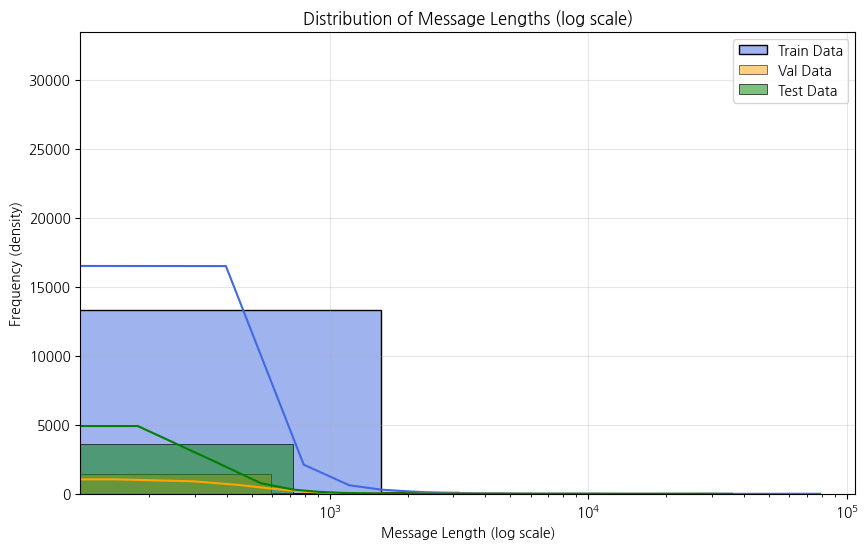

In [9]:
# 메시지 길이 계산
train_lengths = [len(word_tokenize(msg)) for msg in train_texts]
val_lengths = [len(word_tokenize(msg)) for msg in val_texts]
test_lengths = [len(word_tokenize(msg)) for msg in test_texts]

# 시각화
plt.figure(figsize=(10, 6))

# Seaborn KDE(밀도곡선) 기반 히스토그램
sns.histplot(train_lengths, bins=50, kde=True, color='royalblue', label='Train Data', alpha=0.5)
sns.histplot(val_lengths, bins=50, kde=True, color='orange', label='Val Data', alpha=0.5)
sns.histplot(test_lengths, bins=50, kde=True, color='green', label='Test Data', alpha=0.5)

# 로그 스케일 적용
plt.xscale('log')

# 축/제목 설정
plt.xlabel('Message Length (log scale)')
plt.ylabel('Frequency (density)')
plt.title('Distribution of Message Lengths (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## 토큰화와 길이분석

길이 분포를 보고 최대 길이를 유연하게 결정 한다.

In [10]:
def tokenize_corpus(text_list):
    """
    입력 : 문자열 리스트
    출력 : 각 문서를 토큰 리스트로 바꾼 2차원 리스트
    """
    return [clean_and_tokenize(t) for t in text_list]

# train/val/test 코퍼스를 토큰 시퀀스로 변환
train_tokens = tokenize_corpus(train_texts)     # List[str]) -> List[List[str]]
val_tokens = tokenize_corpus(val_texts)
test_tokens = tokenize_corpus(test_texts)

# 각 학습 문서의 토큰 길이를 수집
lengths = [len(toks) for toks in train_tokens]

# 길이 상한 후보를 95%의 데이터가 이하인 값 (롱테일 문서 패딩/메모리 낭비 방지)
max_len = int(np.percentile(lengths, 95))

# 최종길이 규칙 : 최소 토큰은 50으로 보장하고 최대는 400까지만 허용한다. 그 사이의 95퍼센테일 값만 사용
MAX_LEN = max(50, min(max_len, 400))

# 시퀀스 길이 설정을 로그로 확인
print("95퍼센테일 길이: ", max_len, "| 최종길이: ", MAX_LEN)

95퍼센테일 길이:  299 | 최종길이:  299


## Vocabulary & 시퀀스 변환

- 자주 등장하는 토큰으로 어휘 사전 구축
- <pad>와 <unk> 토큰 예약
- 텍스트 >> 인덱스 시퀀스 >> 고정 길이 패딩

In [11]:
def build_vocab(token_lists, min_freq=3, max_size=30000):
    # 코퍼스 전체 토큰 빈도 집계
    counter = Counter(tok for tokens in token_lists for tok in tokens)
    # 상위 max_size개만 추출
    most_common = counter.most_common(max_size)
    # 특별 토큰 사전 초기화 (패딩0, 미등록어1)
    vocab = {'<pad>':0, '<unk>':1}
    for word, freq in most_common:
        # 최소등장 빈도 미만 단어는 제외
        if freq < min_freq:
            continue
        # 이미 존재하지 않으면 현재 길이로 등록
        vocab.setdefault(word, len(vocab))
    return vocab

# 학습 코퍼스에서 단어 사전 생성 : 매우 드문 단어 제외, 상한 4000
vocab = build_vocab(train_tokens, min_freq=5, max_size=40000)
print(f'Vocabulary size:', len(vocab))

def tokens_to_indices(tokens, vocab, max_len):
    # 미등록어 인덱스 캐싱
    unk = vocab['<unk>']
    # 토큰 인텍스 매핑 (vocab에 없으면 <unk> 인덱스 사용)
    idxs = [vocab.get(tok, unk) for tok in tokens][:max_len]
    # 패딩 : max_len보다 짧으면 <pad>(0)으로 패딩하여 고정 길이 시퀀스 구성
    if len(idxs) < max_len:
        idxs += [vocab['<pad>']] * (max_len - len(idxs))
    return idxs

# Train/Val/Test 토큰시퀀스를 모두 정수 인덱스 시퀀스로 변경
train_indices = [tokens_to_indices(t, vocab, MAX_LEN) for t in train_tokens]
val_indices = [tokens_to_indices(t, vocab, MAX_LEN) for t in val_tokens]
test_indices = [tokens_to_indices(t, vocab, MAX_LEN) for t in test_tokens]

Vocabulary size: 21738


# 임베딩
## 임베딩 생성 유틸리티

Word2Vec / FastText 학습, GloVe 로딩을 함수화 한다

In [12]:
# GloVe 사전학습 임베딩: torchtext가 설치/호환될 때만 사용
try:
    from torchtext.vocab import GloVe          # 사전 학습된 GloVe 벡터 로더
    TORCHTEXT_AVAILABLE = True                 # 사용 가능 플래그
except Exception:
    TORCHTEXT_AVAILABLE = False                # 환경에 따라 미지원일 수 있으므로 안전 처리

/home/jayden86/miniconda3/envs/ai5_project1/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/jayden86/miniconda3/envs/ai5_project1/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [13]:
EMBED_DIM = 100         # 임베딩 벡터 차원 수(공통값)

def train_word2vec(sentences, vector_size=EMBED_DIM):
    """
    Word2Vec 임베딩 학습 함수
    - sentences : 토큰화된 문장 리스트
    - vector_size : 단어 벡터 차원
    - window=5 : 목표 단어 좌우로 5개의 문맥 단어 고려
    - min_count=5 : 등장 빈도 5 미만 단어는 무시
    - workers=4 : 멀티코어 병렬 학습 스레드 수
    - sg=1 : Skip-gram(1) / CBOW(0). Skip-gram은 희귀 단어 학습에 상대적으로 강함
    """
    model = Word2Vec(sentences=sentences, vector_size=vector_size, window=5, min_count=5, workers=4, sg=1)
    return model        # 학습된 모델 반환

def train_fasttext(sentences, vector_size=EMBED_DIM):
    """
    FastText 임베딩 학습 함수
    - FastText는 서브워드(문자 n-gram) 단위로 임베딩을 학습 → 희귀/신조어 처리에 유리
    - 파라미터 의미는 Word2Vec과 유사(Window, min_count, workers 등)
    """
    model = FastText(sentences=sentences, vector_size=vector_size, window=5, min_count=5, workers=4)
    return model

def load_glove(vector_size=EMBED_DIM):
    """
    사전학습된 GolVe 임베딩 로드
    """
    if not TORCHTEXT_AVAILABLE:
        # 사용 불가 시 명확한 예외 메시지로 수동 로드 유도
        raise RuntimeError('torchtext를 사용할 수 없습니다. GloVe 벡터 파일을 수동으로 로드하세요.')
    # name='6B' : 6 Billion 토큰 코퍼스에서 학습됨 glove세트 사용 // dim=vector_size : 임베딩 차원(50/100/200/300 중 제공)
    glove = GloVe(name='6B', dim=vector_size)
    return glove        # torchtext.vocab.Vectors와 유사한 객체

def build_embedding_matrix(vocab, embeddings, kind):
    """
    vocab의 각 단어 인덱스에 맞춰 임베딩 행렬 생성
    행렬크기 : vocab크기, EMBED_DIM
    """
    matrix = np.random.normal(scale=0.2, size=(len(vocab), EMBED_DIM))
    # 패딩 토큰은 반드시 영벡터(0)로 고정 >> 패딩이 모델에 신호를 주지 않게 함
    matrix[vocab['<pad>']] = np.zeros(EMBED_DIM)

    # vocab을 순회하며 해당단어의 학습된 임베딩 벡터를 찾아 행렬 맵핑
    for word, idx in vocab.items():
        if word in ('<pad>', '<unk>'):
            # 패딩/미등록 토큰은 스킵
            continue
        vector = None

        # Word2Vec/FastText : embeddings.wv에 단어 존재 여부 확인 후 벡터 취득
        if kind == "word2vec" and word in embeddings.wv:
            vector = embeddings.wv[word]
        elif kind == 'fasttext' and word in embeddings.wv:
            vector = embeddings.wv[word]

        # torchtext GloVe : 단어 인덱스로 위치 조회 후 벡터인덱스에서 벡터 취득
        elif kind == 'glove':
            if hasattr(embeddings, 'vectors'):      # 안정성 체크
                token_index = embeddings.stoi.get(word)
                if token_index is not None:
                    vector = embeddings.vectors[token_index].numpy()

        if vector is not None:
            matrix[idx] = vector

    # float32로 캐스팅
    return matrix.astype(np.float32)


## Dataset/DataLoader

시퀀스와 레이블을 텐서로 감싸는 간단한 Dataset을 정의 하고, DataLoader를 구성한다.

In [14]:
# Dataset

class NewsDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.long)      # 각 문서가 정수 인덱스로 변화된 시퀀스
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)     # 전제 데이터의 샘플 개수를 반환
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]        # idx번재 문장의 토큰 시퀀스와 정답 라벨을(X, y) 형태로 반환
    
# NewsDataset 객체 생성
train_dataset = NewsDataset(train_indices, train_labels)
val_dataset = NewsDataset(val_indices, val_labels)
test_dataset = NewsDataset(test_indices, test_labels)

# Dataloader : dataset을 감싸서 batch단위로 데이터를 제공
# - batch_size: 한 번에 모델에 공급할 샘플 수
# - shuffle=True: 학습 시 데이터 순서를 섞어서 과적합 방지
# - DataLoader는 __getitem__을 자동으로 반복 호출하여 배치 텐서를 구성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)   # 학습용 데이터 (랜덤셔플)
val_loader = DataLoader(val_dataset, batch_size=64)                     # 검증용 데이터 (순서유지)
test_loader = DataLoader(test_dataset, batch_size=64)                   # 테스트용 데이터 (순서유지)

## RNN 분류 모델

- 임베딩 레이버(사전학습 가중치 로드 가능)
- 양방향 LSTM
- 풀링/FC 분류기

In [21]:
# 텍스트 분류 모델 정의 RNN_LSTM구조

class TextClassifierRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pretrained_weights=None, freeze_embedding=False):
        """
        vocab_size: 전체 단어 사전 크기 (Embedding lookup table 행 개수)
        embed_dim: 임베딩 벡터 차원 수
        hidden_dim: LSTM의 은닉 상태(hidden state) 크기
        num_classes: 예측할 클래스 개수 (출력 차원)
        pretrained_weights: 사전학습된 임베딩 행렬 (Word2Vec/FastText/GloVe)
        freeze_embedding: True면 임베딩을 학습시키지 않고 고정(freeze)
        """
        super().__init__()
        # 임베딩 레이어 : 단어 인덱스를 실수 벡터로 변환
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # 사전 학습된 임베딩 가중치가 있다면 해당 행렬을 복사
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.tensor(pretrained_weights))

        # freeze 설정 : False >> 학습가능 / True >> 가중치 고정
        self.embedding.weight.requires_grad = not freeze_embedding

        # 양방향 LSTM 인코더
        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        # - batch_first=True → 입력 형태를 (batch, seq, feature)로 지정
        # - bidirectional=True → 양방향 LSTM (정방향 + 역방향) 사용

        # Dropout : 과적합 방지를 위해 일부 뉴런을 확률적으로 30% 끔
        self.dropout = nn.Dropout(0.3)

        # 양방향 LSTM의 출력은 hidden_dim * 2 이므로 입력 차원을 2배로 지정
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):                                   # 순전파
        embeds = self.embedding(x)                          # 단어 인덱스 >> 임베딩 벡터 변환
        outputs, _ = self.encoder(embeds)                   # LSTM 인코더 통과 (ouputs : 각 시점의 은닉상태 전체 시퀀스)
        pooled = outputs.mean(dim=1)                        # 시퀀스 차원 평균 풀링
        logits = self.classifier(self.dropout(pooled))      # Dropout >> Linear 분류기 통과 >> 로짓 출력
        return logits

## 학습/검증 루프

In [22]:
# 모델 학습
def run_epoch(model, loader, criterion, optimizer=None):
    # 학습 모드 여부 결정(optimizer가 있으면 학습, 없으면 평가)
    is_train = optimizer is not None
    # 모델 모드 설정
    model.train() if is_train else model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # 학습 모드일때만 gradient 계산 활성화, 평가시 비활성
        with torch.set_grad_enabled(is_train):
            logits = model(inputs)
            loss = criterion(logits, targets)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)       # 그라디언트 폭주 방지
                optimizer.step()

        # 손실 누적
        total_loss += loss.item() * inputs.size(0)
        # 예측갑 계산
        preds = torch.argmax(logits, dim=1)
        # cpu이동 후 리스트에 저장
        all_preds.append(preds.cpu())
        all_labels.append(targets.cpu())

    # 평균 손실 계산
    avg_loss = total_loss / len(loader.dataset)
    # accuracy 계산
    accuracy = accuracy_score(torch.cat(all_labels), torch.cat(all_preds))
    # 평균 손실과 정확도 반환
    return avg_loss, accuracy

In [ ]:
# 모델 성능 평가

def evaluate_model(model, loader):
    # 출력 : classification_report(precision, recall, f1_score등)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs = inputs.to(device)
            logits = model(inputs)
            preds = torch.argmax(logits, dim=1)
            # 결과 저장
            all_preds.append(preds.cpu())
            all_labels.append(targets)

    # 전체 예측/정답 배열 연결
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()

    # Precision, Recall, F1-score 상세 지표 출력
    print(classification_report(y_true, y_pred, target_names=label_names))


## 임베딩별 실험

In [34]:
import copy 

# 하나의 임베딩을 선택해 벡터학습 >> 임베딩 구성 >> RNN학습/테스트까지 전체 파이프라인을 실행
def run_experiment(embedding_type, epochs=3, freeze_embedding=False):
    # 학습 코퍼스로 word2vec 임베딩을 학습
    if embedding_type == "word2vec":
        vectors = train_word2vec(train_tokens)
    # 학습 코퍼스로 fasttext 임베딩을 학습
    elif embedding_type == "fasttext":
        vectors = train_fasttext(train_tokens)
    # 사전학습된 glove 벡터 로드
    elif embedding_type == "glove":
        vectors = load_glove()
    else:
        # 안전 장치
        raise ValueError('지원하지 않는 문자열 입력 시 즉시 실패')
    
    # vocab에 맞춘 임베딩 행렬 생성
    embedding_matrix = build_embedding_matrix(vocab, vectors, embedding_type)
    # 텍스트 불류 모델 RNN 구성
    model = TextClassifierRNN(
        vocab_size=len(vocab),
        embed_dim=EMBED_DIM,
        hidden_dim=128,
        num_classes=len(label_names),
        pretrained_weights=embedding_matrix,
        freeze_embedding=freeze_embedding
    ).to(device)

    # 손실 함수
    criterion = nn.CrossEntropyLoss()
    # 옵티마이저
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    history = []        # 에폭 성능 로그 기록
    best_val = -1
    best_state = None    

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = run_epoch(model, val_loader, criterion)

        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc,
        })
        if val_acc > best_val:
            best_val = val_acc
            best_state = copy.deepcopy(model.state_dict())

        # 진행 상황 출력
        print(f'[{embedding_type}] Epoch {epoch}: train_acc={train_acc:.4f} val_acc={val_acc:.4f}')

    # 검증 정확도의 최고치 요약 출력
    print(f"[{embedding_type}] 검증 성능 최고치: {best_val:.4f}")
    # 최종 테스트 리포드 출력
    print('테스트 리포트:')
    evaluate_model(model, test_loader)

    return history, best_state
    

## 개별 실행
각 임베딩을 **순차적으로** 실행해 결과를 비교. 먼저 공용 이력을 저장할 딕셔너리를 초기화한 뒤, Word2Vec → FastText → GloVe 순으로 셀을 실행

In [35]:
# 공용 딕셔너리
experiment_histories = {}
print('실험 이력 딕셔너리를 초기화했습니다.')

실험 이력 딕셔너리를 초기화했습니다.


### Word2Vec + LSTM

In [36]:
print('===== Word2Vec 실험 시작 =====')
word2vec_history, word2vec_state = run_experiment('word2vec', epochs=50)
experiment_histories['word2vec'] = word2vec_history

word2vec_model = TextClassifierRNN(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_dim=128,
    num_classes=len(label_names),
    pretrained_weights=None,
    freeze_embedding=False,
).to(device)
word2vec_model.load_state_dict(word2vec_state)
print('Word2Vec 실험 완료')


===== Word2Vec 실험 시작 =====
[word2vec] Epoch 1: train_acc=0.1712 val_acc=0.2487
[word2vec] Epoch 2: train_acc=0.3135 val_acc=0.3667
[word2vec] Epoch 3: train_acc=0.3961 val_acc=0.4264
[word2vec] Epoch 4: train_acc=0.4569 val_acc=0.4324
[word2vec] Epoch 5: train_acc=0.5115 val_acc=0.4841
[word2vec] Epoch 6: train_acc=0.5562 val_acc=0.5351
[word2vec] Epoch 7: train_acc=0.6066 val_acc=0.5279
[word2vec] Epoch 8: train_acc=0.6411 val_acc=0.5517
[word2vec] Epoch 9: train_acc=0.6722 val_acc=0.5836
[word2vec] Epoch 10: train_acc=0.7106 val_acc=0.5829
[word2vec] Epoch 11: train_acc=0.7369 val_acc=0.5942
[word2vec] Epoch 12: train_acc=0.7608 val_acc=0.6015
[word2vec] Epoch 13: train_acc=0.7869 val_acc=0.6333
[word2vec] Epoch 14: train_acc=0.8115 val_acc=0.6333
[word2vec] Epoch 15: train_acc=0.8303 val_acc=0.6346
[word2vec] Epoch 16: train_acc=0.8424 val_acc=0.6412
[word2vec] Epoch 17: train_acc=0.8552 val_acc=0.6286
[word2vec] Epoch 18: train_acc=0.8702 val_acc=0.6406
[word2vec] Epoch 19: train_a

###

### FastText + LSTM

In [37]:
print('===== FastText 실험 시작 =====')
fasttext_history, fasttext_state = run_experiment('fasttext', epochs=50)
experiment_histories['fasttext'] = fasttext_history

fasttext_model = TextClassifierRNN(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_dim=128,
    num_classes=len(label_names),
    pretrained_weights=None,
    freeze_embedding=False,
).to(device)
fasttext_model.load_state_dict(fasttext_state)
print('FastText 실험 완료')


===== FastText 실험 시작 =====
[fasttext] Epoch 1: train_acc=0.2061 val_acc=0.2619
[fasttext] Epoch 2: train_acc=0.3161 val_acc=0.3488
[fasttext] Epoch 3: train_acc=0.3634 val_acc=0.3700
[fasttext] Epoch 4: train_acc=0.4107 val_acc=0.4125
[fasttext] Epoch 5: train_acc=0.4574 val_acc=0.4403
[fasttext] Epoch 6: train_acc=0.5088 val_acc=0.4721
[fasttext] Epoch 7: train_acc=0.5490 val_acc=0.5040
[fasttext] Epoch 8: train_acc=0.5843 val_acc=0.5385
[fasttext] Epoch 9: train_acc=0.6296 val_acc=0.5637
[fasttext] Epoch 10: train_acc=0.6675 val_acc=0.5670
[fasttext] Epoch 11: train_acc=0.7056 val_acc=0.5802
[fasttext] Epoch 12: train_acc=0.7326 val_acc=0.5829
[fasttext] Epoch 13: train_acc=0.7544 val_acc=0.6034
[fasttext] Epoch 14: train_acc=0.7825 val_acc=0.6141
[fasttext] Epoch 15: train_acc=0.7989 val_acc=0.6088
[fasttext] Epoch 16: train_acc=0.8173 val_acc=0.6227
[fasttext] Epoch 17: train_acc=0.8376 val_acc=0.6160
[fasttext] Epoch 18: train_acc=0.8522 val_acc=0.6260
[fasttext] Epoch 19: train_a

### GloVe + LSTM

In [38]:
if TORCHTEXT_AVAILABLE:
    print('=== GloVe 실험 시작 ===')
    glove_history, glove_state = run_experiment('glove', epochs=50, freeze_embedding=True)
    experiment_histories['glove'] = glove_history

    glove_model = TextClassifierRNN(
        vocab_size=len(vocab),
        embed_dim=EMBED_DIM,
        hidden_dim=128,
        num_classes=len(label_names),
        pretrained_weights=None,
        freeze_embedding=True,
    ).to(device)
    glove_model.load_state_dict(glove_state)
    print('GloVe 실험 완료')
else:
    print('torchtext가 설치/다운로드되지 않아 GloVe 실험을 건너뜁니다.')


=== GloVe 실험 시작 ===
[glove] Epoch 1: train_acc=0.1754 val_acc=0.2407
[glove] Epoch 2: train_acc=0.2782 val_acc=0.2891
[glove] Epoch 3: train_acc=0.3460 val_acc=0.3528
[glove] Epoch 4: train_acc=0.3883 val_acc=0.4218
[glove] Epoch 5: train_acc=0.4350 val_acc=0.4324
[glove] Epoch 6: train_acc=0.4685 val_acc=0.4622
[glove] Epoch 7: train_acc=0.4912 val_acc=0.4675
[glove] Epoch 8: train_acc=0.5072 val_acc=0.4828
[glove] Epoch 9: train_acc=0.5310 val_acc=0.4993
[glove] Epoch 10: train_acc=0.5374 val_acc=0.5060
[glove] Epoch 11: train_acc=0.5466 val_acc=0.5033
[glove] Epoch 12: train_acc=0.5688 val_acc=0.5312
[glove] Epoch 13: train_acc=0.5786 val_acc=0.5305
[glove] Epoch 14: train_acc=0.5917 val_acc=0.5477
[glove] Epoch 15: train_acc=0.6019 val_acc=0.5531
[glove] Epoch 16: train_acc=0.6170 val_acc=0.5749
[glove] Epoch 17: train_acc=0.6255 val_acc=0.5643
[glove] Epoch 18: train_acc=0.6364 val_acc=0.5458
[glove] Epoch 19: train_acc=0.6434 val_acc=0.5610
[glove] Epoch 20: train_acc=0.6534 val_

## 결과 요약 테이블
여러 임베딩의 Val_acc 최고값을 모아 비교

In [39]:
import pandas as pd

rows = []
for name, history in experiment_histories.items():
    """
    experiment_histories: { 'word2vec': [...], 'fasttext': [...], 'glove': [...] }
    각 임베딩 이름(name)과 해당 실험의 히스토리 리스트(history)를 순회
    """
    # 각 임베딩 실험에서 "검증 정확도(val_acc)"가 가장 높은 시점(에폭)을 선택
    best = max(history, key=lambda h: h['val_acc'])
    rows.append({
        'embedding': name,
        'best_epoch': best['epoch'],                # 최고 성능이 나온 에폭 번호
        'best_val_acc': best['val_acc'],            # 최고 검증 정확도
        'train_acc_at_best': best['train_acc']      # 에폭의 학습 정확도
    })

results_df = pd.DataFrame(rows)
# 검증 정확도(best_val_acc)가 높은 순서대로 정렬해 출력
display(results_df.sort_values('best_val_acc', ascending=False))


,embedding,best_epoch,best_val_acc,train_acc_at_best
0,word2vec,38,0.672414,0.953567
1,fasttext,43,0.652520,0.954525
2,glove,41,0.611406,0.799971


# 결과 시각화

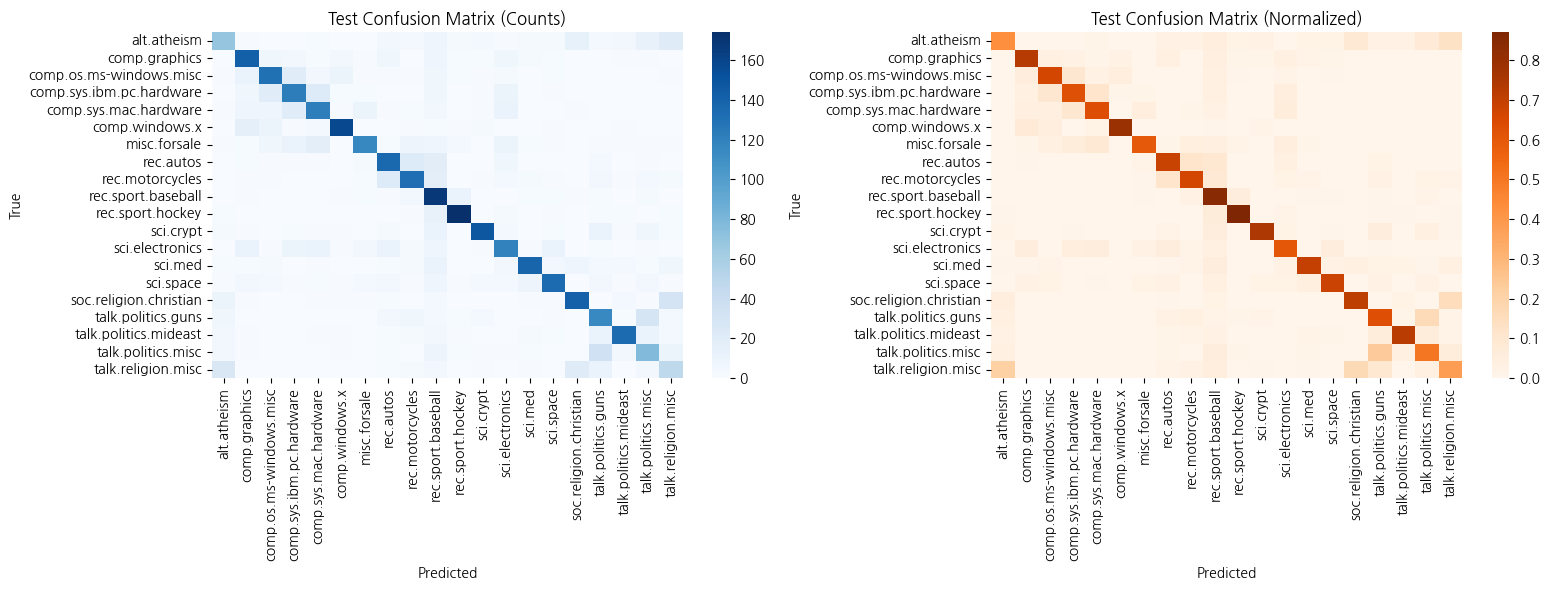

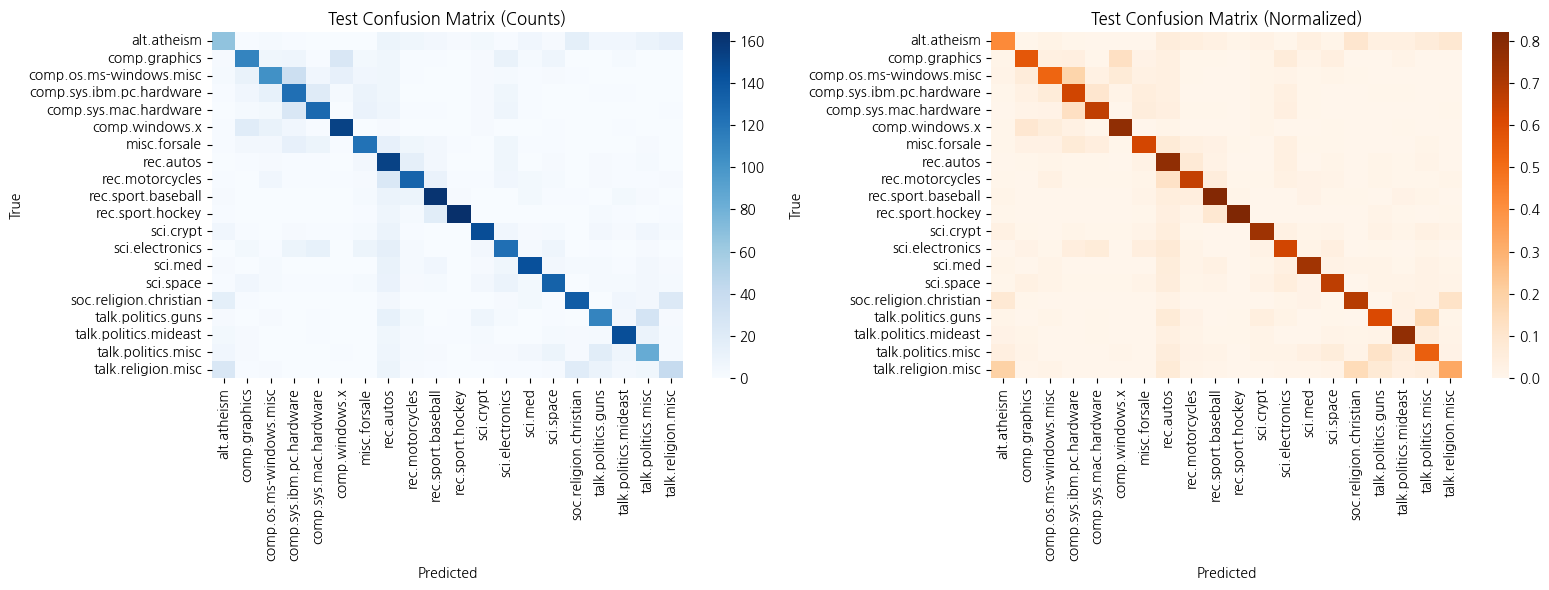

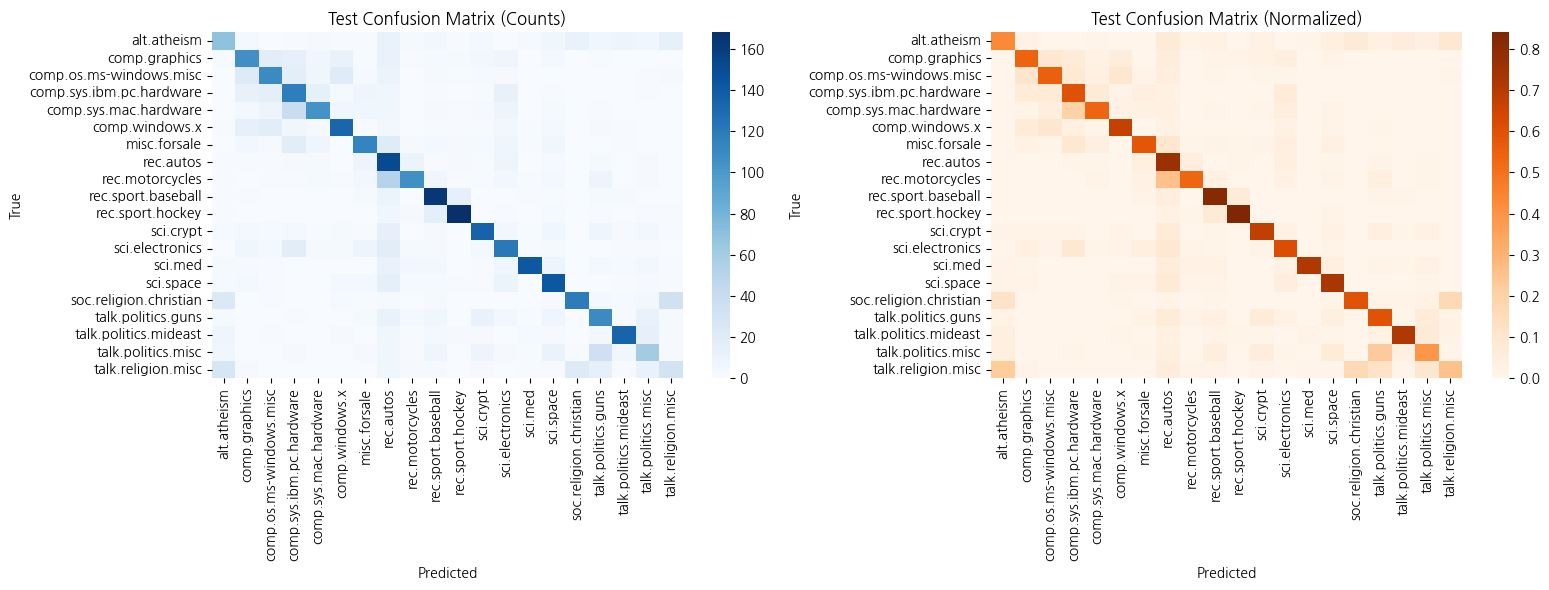

In [43]:
## 1. 혼동 행렬 (정수 / 정규화 버전)

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(model, loader, label_names, device, title='Validation'):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            preds.append(logits.argmax(dim=1).cpu())
            targets.append(yb)

    y_true = torch.cat(targets).numpy()
    y_pred = torch.cat(preds).numpy()

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names, ax=axes[0])
    axes[0].set_title(f'{title} Confusion Matrix (Counts)')
    axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

    sns.heatmap(cm_norm, annot=False, fmt='.2f', cmap='Oranges',
                xticklabels=label_names, yticklabels=label_names, ax=axes[1])
    axes[1].set_title(f'{title} Confusion Matrix (Normalized)')
    axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')
    plt.tight_layout()

# 사용 예시
plot_confusion_matrices(word2vec_model, test_loader, label_names, device, title='Test')
plot_confusion_matrices(fasttext_model, test_loader, label_names, device, title='Test')
plot_confusion_matrices(glove_model, test_loader, label_names, device, title='Test')

In [46]:
## 2. 오분류 사례 테이블 (원문, 정답, 예측, 확률)
import pandas as pd
import torch.nn.functional as F

def collect_misclassified_rows(model, loader, texts, label_names, device, top_k=15):
    model.eval()
    rows = []
    offset = 0                      # DataLoader 순서를 원본 텍스트 인덱스와 매칭

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = F.softmax(logits, dim=1)
            pred_ids = probs.argmax(dim=1).cpu()
            batch = xb.size(0)

            for i in range(batch):
                true_id = yb[i].item()
                pred_id = pred_ids[i].item()
                if true_id == pred_id:
                    continue
                rows.append({
                    'text_preview': texts[offset + i][:400].replace('\\n', ' '),
                    'true_label': label_names[true_id],
                    'pred_label': label_names[pred_id],
                    'pred_confidence': float(probs[i, pred_id].cpu())
                })
            offset += batch

    df = pd.DataFrame(rows)
    return df.sort_values('pred_confidence', ascending=False).head(top_k)

# 사용 예시 (검증 세트 상위 10건)
word2vec_mis_val = collect_misclassified_rows(word2vec_model, val_loader, val_texts, label_names, device, top_k=10)
fasttext_mis_val = collect_misclassified_rows(fasttext_model, val_loader, val_texts, label_names, device, top_k=10)
glove_mis_val = collect_misclassified_rows(glove_model, val_loader, val_texts, label_names, device, top_k=10)
print("=====word2vec_missing=====")
display(word2vec_mis_val)
print("=====fasttext_missing=====")
display(fasttext_mis_val)
print("=====glove_missing=====")
display(glove_mis_val)

=====word2vec_missing=====


,text_preview,true_label,pred_label,pred_confidence
286,\nThe Supreme Court seems to disagree with you...,sci.crypt,talk.politics.guns,1.000000
70,"\nNo, this is far from clear. We only have th...",talk.religion.misc,talk.politics.guns,1.000000
455,"Los Angeles Times, Saturday, May 8, 1993. Pag...",talk.politics.mideast,talk.politics.misc,1.000000
225,"I got a number of requests for code.\nSo, here...",sci.crypt,rec.motorcycles,0.999999
97,Here is a press release from the White House.\...,talk.politics.guns,talk.politics.misc,0.999998
309,"\nYup, I bought the darn thing cause it was st...",comp.sys.mac.hardware,misc.forsale,0.999997
310,pmoloney@maths.tcd.ie (Paul Moloney) writes......,talk.religion.misc,talk.politics.guns,0.999997
92,Welcome to the Peace Run\n\n ...,talk.religion.misc,talk.politics.mideast,0.999993
335,"G'Day\n\nWindows NT is a step forward, but not...",comp.windows.x,comp.os.ms-windows.misc,0.999993
2,"\nThat study which was in the NEJM, I think, n...",talk.politics.misc,sci.med,0.999991


=====fasttext_missing=====


,text_preview,true_label,pred_label,pred_confidence
94,Here is a press release from the White House.\...,talk.politics.guns,talk.politics.misc,1.000000
36,\n\n\n\n[...]\n\n\nI think you are mistaken in...,talk.religion.misc,alt.atheism,0.999999
45,"\n\nJesus also recognized other holy days, lik...",talk.religion.misc,soc.religion.christian,0.999989
319,"\n\nJust a thought on resources, It is very i...",comp.os.ms-windows.misc,comp.windows.x,0.999989
377,"^^^^^^^^\n\nWell, I'm not sure I'd go quite ...",misc.forsale,sci.electronics,0.999987
69,"\nNo, this is far from clear. We only have th...",talk.religion.misc,talk.politics.guns,0.999985
522,"\n\n\nFor a good display, you *must* get an ac...",comp.sys.mac.hardware,sci.electronics,0.999953
58,MK48T02 from thomsom. It has a timekeeper (cl...,rec.autos,sci.electronics,0.999949
330,"\ni installed dos 6 last week, and had nothing...",misc.forsale,comp.os.ms-windows.misc,0.999945
245,[This was crossposted to a zillion groups. I ...,soc.religion.christian,alt.atheism,0.999934


=====glove_missing=====


,text_preview,true_label,pred_label,pred_confidence
379,"\n\nI just installed a MC Power Arc II, and it...",rec.motorcycles,sci.electronics,0.999849
565,I have uploaded the most recent Windows driver...,comp.sys.ibm.pc.hardware,comp.os.ms-windows.misc,0.999818
540,"Los Angeles Times, Saturday, May 8, 1993. Pag...",talk.politics.mideast,talk.politics.misc,0.999816
316,"\n: I have seen these numbers quoted before, a...",talk.politics.guns,sci.crypt,0.999758
350,\nThe Supreme Court seems to disagree with you...,sci.crypt,talk.politics.guns,0.999756
6,"\nThe only way to change ESPN's thinking, if i...",rec.sport.hockey,rec.sport.baseball,0.999557
337,Archive-name: rec-autos/part4\n\n[this article...,rec.autos,sci.electronics,0.999266
524,\n That brings up an interesting point. Anyon...,rec.sport.baseball,rec.sport.hockey,0.999050
351,THE WHITE HOUSE\n\n Office of...,talk.politics.misc,sci.space,0.998920
135,\n\nI beg to disagree with the assertion that ...,soc.religion.christian,sci.space,0.998570


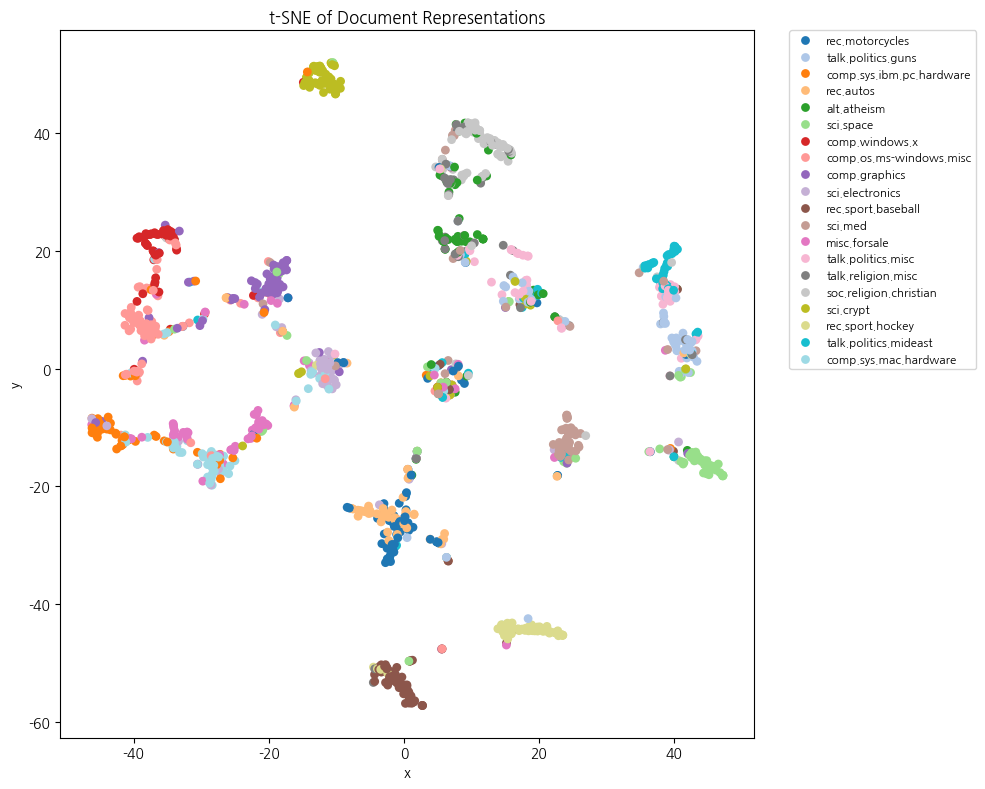

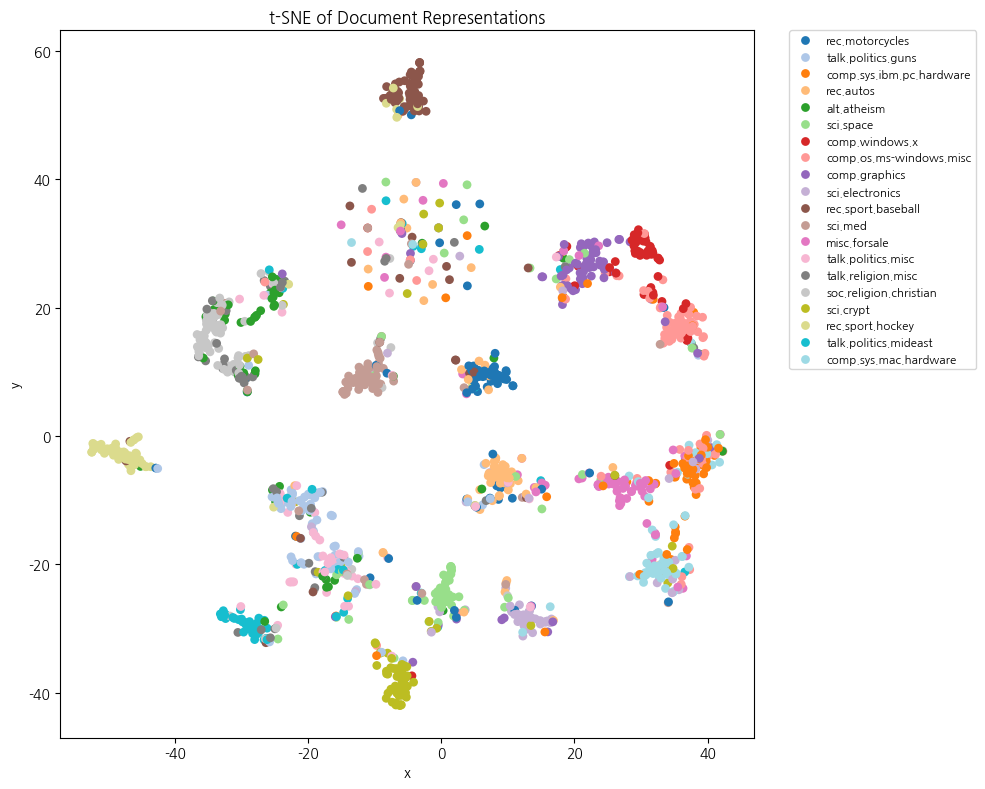

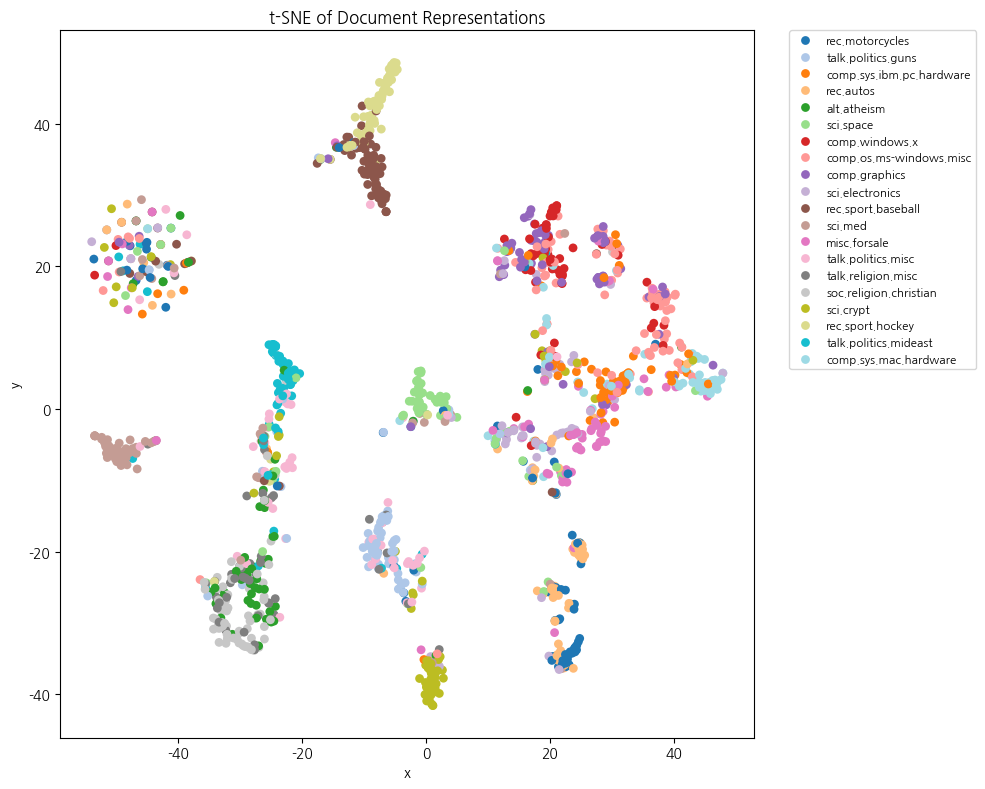

In [48]:
## 3. 문서 임베딩 t-SNE 투영 (클래스별 색상)
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def extract_sequence_representations(model, loader, device):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            embeds = model.embedding(xb)
            outputs, _ = model.encoder(embeds)
            pooled = outputs.mean(dim=1).cpu()
            feats.append(pooled)
            labels.append(yb)
    features = torch.cat(feats).numpy()
    y = torch.cat(labels).numpy()
    return features, y

def plot_tsne_embeddings(model, loader, label_names, device, sample_size=2000, random_state=42):
    features, y = extract_sequence_representations(model, loader, device)

    if sample_size and len(features) > sample_size:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(len(features), size=sample_size, replace=False)
        features = features[idx]
        y = y[idx]

    tsne = TSNE(n_components=2, learning_rate='auto', init='pca',
                random_state=random_state, perplexity=30)
    coords = tsne.fit_transform(features)

    df = pd.DataFrame({
        'x': coords[:, 0],
        'y': coords[:, 1],
        'label': [label_names[i] for i in y]
    })

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='x', y='y', hue='label', palette='tab20', s=40, linewidth=0)
    plt.title('t-SNE of Document Representations')
    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize='small')
    plt.tight_layout()

# 사용 예시
plot_tsne_embeddings(word2vec_model, test_loader, label_names, device, sample_size=1500)
plot_tsne_embeddings(fasttext_model, test_loader, label_names, device, sample_size=1500)
plot_tsne_embeddings(glove_model, test_loader, label_names, device, sample_size=1500)

In [51]:
## 4. 실제 서비스 시나리오용 “문장 → 예측” 미니 데모
def predict_single_text(model, text, vocab, max_len, device, label_names):
    model.eval()
    tokens = clean_and_tokenize(text)
    indices = tokens_to_indices(tokens, vocab, max_len)
    tensor = torch.tensor([indices], dtype=torch.long).to(device)
    with torch.no_grad():
        logits = model(tensor)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
    top_idx = probs.argmax()
    return {
        'text': text,
        'pred_label': label_names[top_idx],
        'confidence': float(probs[top_idx])
    }

# 사용 예시
sample_text = "This graphics card discussion reminds me of older 3D accelerators..."
result = predict_single_text(word2vec_model, sample_text, vocab, MAX_LEN, device, label_names)
print(result)

{'text': 'This graphics card discussion reminds me of older 3D accelerators...', 'pred_label': 'comp.graphics', 'confidence': 0.97621750831604}
